# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [3]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Learn H, A, T from Austin

In [4]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### Transfer learning with A_au

In [96]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt = {}
data_adapt = {}

n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    T_adapt[random_seed] = {}
    data_adapt[random_seed] = {}
    
for random_seed in range(10):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        T_adapt[random_seed][adapt_percentage] = {}
        data_adapt[random_seed][adapt_percentage] = {}
        adapt_max, test = range(35), range(35, 39)


        num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
        num_test = len(test)

        # get the random training data from train_max based on then random seed
        if adapt_percentage == 100:
            adapt = adapt_max
        else:
            adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)

        # get the index of training and testing data
        adapt_ix = sd_df.index[adapt]
        test_ix = sd_df.index[test]

        # create the tensor
        adapt_df = sd_df.ix[adapt_ix]
        test_df = sd_df.ix[test_ix]
        adapt_dfc = sd_dfc.ix[adapt_ix]
        test_dfc = sd_dfc.ix[test_ix]
        adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)

        # use the adpat data with A_au from Austion to learn T_sd_adapt
        H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

        T_adapt[random_seed][adapt_percentage] = T_sd_adapt
        data_adapt[random_seed][adapt_percentage] = adapt_dfc


random seed:  0
adapt percentage:  10
adapt percentage:  20
adapt percentage:  30
adapt percentage:  40
adapt percentage:  50
adapt percentage:  60
adapt percentage:  70
adapt percentage:  80
adapt percentage:  90
adapt percentage:  100
random seed:  1
adapt percentage:  10
adapt percentage:  20
adapt percentage:  30
adapt percentage:  40
adapt percentage:  50
adapt percentage:  60
adapt percentage:  70
adapt percentage:  80
adapt percentage:  90
adapt percentage:  100
random seed:  2
adapt percentage:  10
adapt percentage:  20
adapt percentage:  30
adapt percentage:  40
adapt percentage:  50
adapt percentage:  60
adapt percentage:  70
adapt percentage:  80
adapt percentage:  90
adapt percentage:  100
random seed:  3
adapt percentage:  10
adapt percentage:  20
adapt percentage:  30
adapt percentage:  40
adapt percentage:  50
adapt percentage:  60
adapt percentage:  70
adapt percentage:  80
adapt percentage:  90
adapt percentage:  100
random seed:  4
adapt percentage:  10
adapt percenta

In [97]:
T_adapt[0][20]

array([[ 2.55560181,  0.        ],
       [ 2.3786082 ,  0.        ],
       [ 2.42427556,  0.        ],
       [ 2.59842753,  0.00636965],
       [ 2.28775585,  1.6538728 ],
       [ 2.93493525,  1.03851785],
       [ 1.59396297,  3.43130352],
       [ 1.4980316 ,  4.02923695],
       [ 1.3971084 ,  4.03833645],
       [ 2.6589035 ,  1.47354344],
       [ 2.7870765 ,  0.        ],
       [ 3.66314713,  0.        ]])

In [95]:
T_adapt[0][20][0]

array([[ 2.55560181,  0.        ],
       [ 2.3786082 ,  0.        ],
       [ 2.42427556,  0.        ],
       [ 2.59842753,  0.00636965],
       [ 2.28775585,  1.6538728 ],
       [ 2.93493525,  1.03851785],
       [ 1.59396297,  3.43130352],
       [ 1.4980316 ,  4.02923695],
       [ 1.3971084 ,  4.03833645],
       [ 2.6589035 ,  1.47354344],
       [ 2.7870765 ,  0.        ],
       [ 3.66314713,  0.        ]])

In [36]:
d.mean(axis=1)

1     409.812378
2     359.609955
3     348.912496
4     333.515180
5     429.855896
6     366.686626
7     530.478208
8     581.806200
9     594.883702
10    446.776513
11    340.709305
12    396.420473
dtype: float64


[MoviePy] Building file matplotlib.gif with imageio


 98%|█████████▊| 60/61 [00:05<00:00, 10.06it/s]


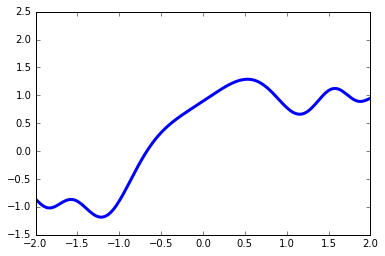

In [39]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 2

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
    ax.set_ylim(-1.5, 2.5)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.write_gif('matplotlib.gif', fps=30)

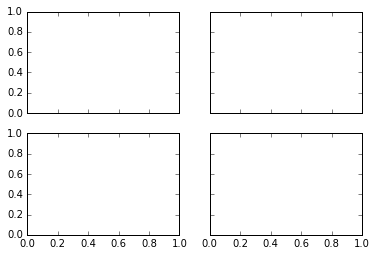

In [59]:
test_set_num = 3
train_percentage = 20
fig, ax = plt.subplots(nrows=2, ncols = 2, sharex=True, sharey=True)
duration = 10

#animation = VideoClip(make_frame, duration=duration)
#animation.write_gif('matplotlib.gif', fps=1) 

In [60]:
for a in ax:
    print a

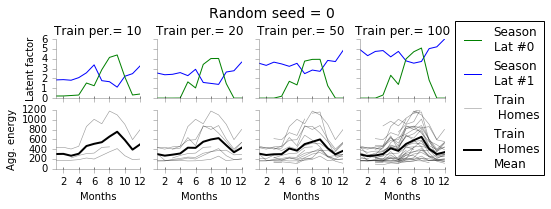

In [151]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(8, 3), nrows=2, sharex=True,  ncols=4)
fig.subplots_adjust(top=0.8, right=0.8, bottom=0.2)
#fig.subplots_adjust(bottom=0.85)  

import matplotlib.lines as mlines
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Lat #0')

blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Lat #1')
lgd = ax[0, 3].legend(bbox_to_anchor=(2,0), loc="center right",handles=[green_line, blue_line],ncol=1)

from plot_functions import *
def make_frame(random_seed):
    for a in ax:
        for b in a:
            b.clear()
    st = plt.suptitle("Random seed = %d\n" %random_seed, fontsize=14)
    st.set_y(0.95)
    for i, train_percentage in enumerate([10, 20, 50, 100]):
        
        t = pd.DataFrame(T_adapt[random_seed][train_percentage])
        t.index = range(1, 13)
        t.plot(ax=ax[0, i], legend=False)
        
        d = data_adapt[random_seed][train_percentage][['aggregate_%d' %month for month in range(1, 13)]].T
        d.index = range(1, 13)
        d.plot(color='k', alpha=0.4, legend=False, ax=ax[1, i], linewidth=0.6)
        d.mean(axis=1).plot(color='k', linewidth=2, ax=ax[1, i])
        ax[1, i].set_xlabel("Months")
        ax[0, i].set_title("Train per.= %d" %train_percentage)
        ax[0, i].set_ylim((0, 6))
        ax[1, i].set_ylim((0, 1200))
        if i>0:
            ax[1, i].yaxis.set_ticklabels([])
            ax[0, i].yaxis.set_ticklabels([])
    
    
    ax[0, 0].set_ylabel("Latent factor")
    ax[1, 0].set_ylabel("Agg. energy")
    for a in ax:
        for b in a:
            format_axes(b)
    
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Season\nLat #0')
    blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Season\nLat #1')
    light_black_line = mlines.Line2D([], [], color='black',alpha=.4, linewidth=0.6, markersize=15, label='Train\n Homes')
    dark_black_line = mlines.Line2D([], [], color='black',alpha=1, linewidth=2, markersize=15, label='Train\n Homes\nMean')
    lgd = ax[0, 3].legend(bbox_to_anchor=(2.25,0), loc="center right",handles=[green_line, blue_line, light_black_line, dark_black_line],ncol=1)
    
    #fig.tight_layout()
    return mplfig_to_npimage(fig)



anim = FuncAnimation(fig, make_frame, frames=range(10), interval=500)
anim.save('season.gif', dpi=80, writer='imagemagick')


#plt.close()

In [59]:
T = T_adapt[0][10][0]
for i in range(1, 10):
    T = T + T_adapt[0][10][i]
T = T/10
T

array([[ 2.3256582 ,  0.15612203],
       [ 2.24171955,  0.16532875],
       [ 2.21774683,  0.18804444],
       [ 2.4790195 ,  0.28534673],
       [ 2.3906688 ,  1.73778479],
       [ 2.59325903,  1.64470658],
       [ 1.54807911,  3.03709477],
       [ 1.71880663,  3.92907553],
       [ 1.89304722,  3.74757453],
       [ 1.99034373,  2.17798406],
       [ 2.43554863,  0.4722404 ],
       [ 2.39295005,  1.43008103]])

In [61]:
# T = []*10
T = []
for per in range(10, 110, 10):
    T_temp = 0
    for random_seed in range(10):
        for rd in range(10):
            T_temp += T_adapt[random_seed][per][rd]
    T_temp = T_temp/100
    T.append(T_temp)

In [62]:
T

[array([[ 1.61771461,  0.52649496],
        [ 1.68673765,  0.27279607],
        [ 1.96674336,  0.29577973],
        [ 2.08610375,  0.30296573],
        [ 2.0437184 ,  1.46274934],
        [ 2.38453801,  1.18419735],
        [ 1.60532218,  3.04960861],
        [ 1.53446995,  3.60641611],
        [ 1.3068633 ,  3.92283305],
        [ 2.07104692,  1.48303168],
        [ 1.85194297,  0.60632761],
        [ 2.44046892,  0.53728986]]), array([[ 2.85344875,  0.10620636],
        [ 2.54407143,  0.03961271],
        [ 2.71020277,  0.0848024 ],
        [ 2.77601243,  0.19943672],
        [ 2.3410592 ,  1.7107016 ],
        [ 2.53840508,  1.22228727],
        [ 1.74841137,  3.35164787],
        [ 1.67950636,  3.85348219],
        [ 1.57720409,  4.33561934],
        [ 2.3281962 ,  1.86229134],
        [ 2.63498756,  0.36906069],
        [ 3.25735553,  0.32021053]]), array([[ 3.2573924 ,  0.08817564],
        [ 2.87505526,  0.0475715 ],
        [ 3.08949488,  0.07600497],
        [ 3.13108191,  0.2

In [63]:
k = T[0].reshape(1, 24)
for i in range(1, 10):
    k = np.r_[k, T[i].reshape(1,24)]
df_T = pd.DataFrame(k)

In [64]:
df_T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.617715,0.526495,1.686738,0.272796,1.966743,0.295780,2.086104,0.302966,2.043718,1.462749,...,1.534470,3.606416,1.306863,3.922833,2.071047,1.483032,1.851943,0.606328,2.440469,0.537290
1,2.853449,0.106206,2.544071,0.039613,2.710203,0.084802,2.776012,0.199437,2.341059,1.710702,...,1.679506,3.853482,1.577204,4.335619,2.328196,1.862291,2.634988,0.369061,3.257356,0.320211
2,3.257392,0.088176,2.875055,0.047571,3.089495,0.076005,3.131082,0.267116,2.638579,1.958739,...,2.021825,4.117495,2.135035,4.452911,2.865883,1.791250,3.228189,0.181238,3.798292,0.200047
3,3.785535,0.044817,3.310379,0.020657,3.585048,0.060757,3.708696,0.273722,3.053442,2.010544,...,2.524595,3.993671,2.784072,4.290143,3.488694,1.673187,3.778564,0.116547,4.403731,0.141226
4,4.127739,0.048406,3.627885,0.015110,3.946452,0.050656,4.061150,0.319808,3.375216,2.042439,...,2.899607,3.913660,3.206867,4.196383,3.886418,1.602928,4.144406,0.097762,4.842082,0.092998
5,4.396858,0.030804,3.907913,0.002715,4.272292,0.025101,4.397732,0.295582,3.777831,2.035497,...,3.263256,3.992699,3.538150,4.312616,4.282764,1.663062,4.569849,0.075626,5.334718,0.074046
6,4.637293,0.027491,4.107683,0.000410,4.517605,0.017487,4.657740,0.312465,3.915232,2.140793,...,3.367224,4.113560,3.705652,4.403128,4.518711,1.684615,4.822433,0.050841,5.575212,0.059058
7,4.945728,0.008415,4.321256,0.000000,4.773346,0.010952,4.835564,0.326058,4.085971,2.220796,...,3.515114,4.276580,3.883082,4.566345,4.711194,1.688143,5.033517,0.021417,5.815033,0.027993
8,5.051851,0.002607,4.406295,0.000000,4.869007,0.002291,4.913552,0.314042,4.186837,2.239395,...,3.604272,4.361937,3.951080,4.670125,4.871933,1.737320,5.199090,0.012998,5.932555,0.027310
9,5.097070,0.000000,4.472993,0.000000,4.936510,0.000000,4.968276,0.307655,4.257152,2.311399,...,3.607275,4.590381,3.924187,4.911531,4.942907,1.825625,5.280341,0.002857,6.066424,0.017234


In [143]:
index=1
y_1 = df_T.loc[index:10].iloc[:, [0,2,4,6,8,10,12,14,16,18,20,22]]
y_2 = df_T.loc[index:10].iloc[:, [1,3,5,7,9,11,13,15,17,19,21,23]]

In [144]:
y_mean_1 = y_1.mean().values
y_mean_2 = y_2.mean().values
y_std_1 = y_1.std().values
y_std_2 = y_2.std().values

In [145]:
x_idx = [1,2,3,4,5,6,7,8,9,10,11,12]

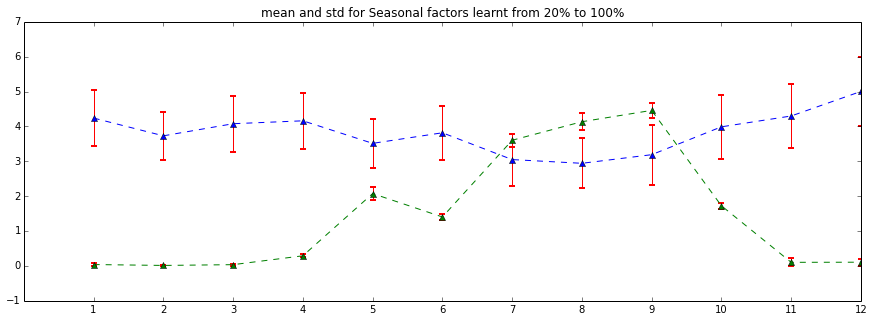

In [147]:
plt.figure(figsize=(15, 5))
plt.errorbar(x_idx, y_mean_1, yerr = y_std_1,  linestyle='--', fmt='^', ecolor='r', capthick=2)
plt.errorbar(x_idx, y_mean_2, yerr = y_std_2,  linestyle='--', fmt='^', ecolor='r', capthick=2)
plt.xticks(x_idx)
plt.title("mean and std for Seasonal factors learnt from 20% to 100%")

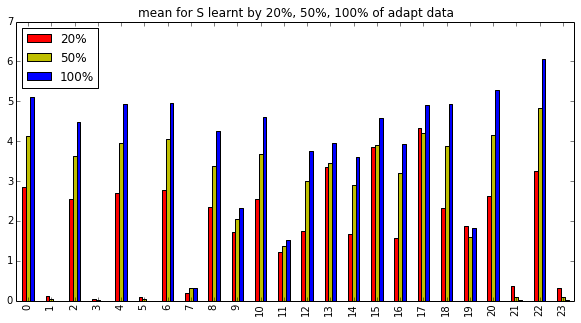

In [69]:
df_T.loc[[1, 4, 9]].T.rename(columns={1: "20%", 4:"50%", 9:"100%"}).plot(kind='bar', color=['r', 'y', 'b'], figsize=(10, 5))
# plt.legend([index, 9], ['20%', '100%'])
plt.title("mean for S learnt by 20%, 50%, 100% of adapt data")

